In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import kagglehub
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import wandb
from wandb.integration.keras import WandbCallback
from datetime import datetime

In [3]:
path = kagglehub.dataset_download('anshtanwar/jellyfish-types')
print("데이터셋 파일 경로:", path)

데이터셋 파일 경로: /kaggle/input/jellyfish-types


In [4]:
print("다운로드된 파일 목록:")
print(os.listdir(path))

다운로드된 파일 목록:
['Train_Test_Valid', 'Moon_jellyfish', 'blue_jellyfish', 'mauve_stinger_jellyfish', 'barrel_jellyfish', 'lions_mane_jellyfish', 'compass_jellyfish']


In [5]:
# 폴더 구조 확인
train_test_valid_path = os.path.join(path, 'Train_Test_Valid')
if os.path.exists(train_test_valid_path):
    print("\nTrain_Test_Valid 폴더 내용:")
    print(os.listdir(train_test_valid_path))

    # 훈련 데이터 경로
    train_path = os.path.join(train_test_valid_path, 'Train')
    if os.path.exists(train_path):
        train_files = pd.DataFrame(os.listdir(train_path), columns=['Files_Name'])
        print("\n훈련 파일:")
        print(train_files.head())
    else:
        print(f"\n'Train' 폴더를 찾을 수 없습니다.")

    # 검증 데이터 경로
    valid_path = os.path.join(train_test_valid_path, 'valid')
    if os.path.exists(valid_path):
        valid_files = pd.DataFrame(os.listdir(valid_path), columns=['Files_Name'])
        print("\n검증 파일:")
        print(valid_files.head())
    else:
        print(f"\n'valid' 폴더를 찾을 수 없습니다.")
else:
    print(f"\n'Train_Test_Valid' 폴더를 찾을 수 없습니다.")


Train_Test_Valid 폴더 내용:
['valid', 'test', 'Train']

훈련 파일:
                Files_Name
0           Moon_jellyfish
1           blue_jellyfish
2  mauve_stinger_jellyfish
3         barrel_jellyfish
4     lions_mane_jellyfish

검증 파일:
                Files_Name
0           Moon_jellyfish
1           blue_jellyfish
2  mauve_stinger_jellyfish
3         barrel_jellyfish
4     lions_mane_jellyfish


In [6]:
def create_dataframe(image_folder):
    files = glob.glob(os.path.join(image_folder, '**', '*.*'), recursive=True)
    np.random.shuffle(files)
    labels = [os.path.basename(os.path.dirname(f)) for f in files]
    return pd.DataFrame({'Image': files, 'Label': labels})

dataframe_train = create_dataframe(train_path)
dataframe_valid = create_dataframe(valid_path)

Dataset                   Training  Validation
Label                                         
Moon_jellyfish           16.666667   15.384615
barrel_jellyfish         16.666667   12.820513
blue_jellyfish           16.666667   17.948718
compass_jellyfish        16.666667   17.948718
lions_mane_jellyfish     16.666667   17.948718
mauve_stinger_jellyfish  16.666667   17.948718


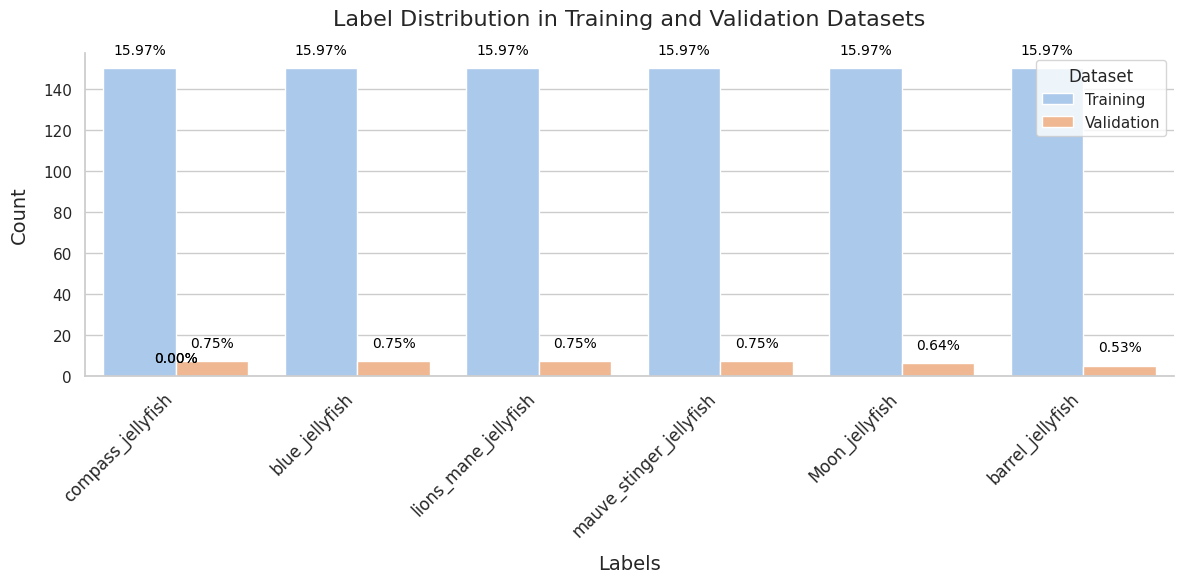

In [7]:
dataframe_train['Dataset'] = 'Training'
dataframe_valid['Dataset'] = 'Validation'

combined_df = pd.concat([dataframe_train, dataframe_valid], ignore_index=True)

sns.set_theme(style="whitegrid")

count_data = combined_df.groupby(['Label', 'Dataset']).size().unstack(fill_value=0)
percentage_data = count_data.div(count_data.sum(axis=0), axis=1) * 100

print(percentage_data)

palette = sns.color_palette("pastel", len(count_data))

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=combined_df, x="Label", hue="Dataset", order=count_data.sum(axis=1).sort_values(ascending=False).index, palette="pastel")

for p in ax.patches:
    height = p.get_height()
    percentage = f'{(height / len(combined_df)) * 100:.2f}%'
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 8), textcoords='offset points')

plt.xticks(rotation=45, ha='right', fontsize=12)

plt.title("Label Distribution in Training and Validation Datasets", fontsize=16, pad=20)
plt.xlabel("Labels", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

sns.despine()

plt.tight_layout()
plt.show()

In [8]:

# def grayscale_transform(img):
#     gray = tf.image.rgb_to_grayscale(img)
#     return tf.tile(gray, [1, 1, 3])  # 단일 채널을 3개로 복제하여 3채널 유지

def random_grayscale(img, p=0.5): # 확률만큼 이미지를 흑백처리
    if np.random.random() < p:
        gray = tf.image.rgb_to_grayscale(img)
        return tf.tile(gray, [1, 1, 3])
    else:
        return img

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.15,
    # zoom_range=0.15,
    # horizontal_flip=True,
    # fill_mode='nearest',
    preprocessing_function=lambda img: random_grayscale(img, p=0.5)  # 흑백 변환
)

valid_datagen = ImageDataGenerator(rescale=1./255)

target_size = (224, 224)
batch_size = 16

In [9]:
# 데이터 제너레이터 생성
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 900 images belonging to 6 classes.
Found 39 images belonging to 6 classes.


In [10]:
batch_size = 16
target_size = (224,224)
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=None,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    validation_split=None,
    image_size=target_size,
    batch_size=batch_size,
)

Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.


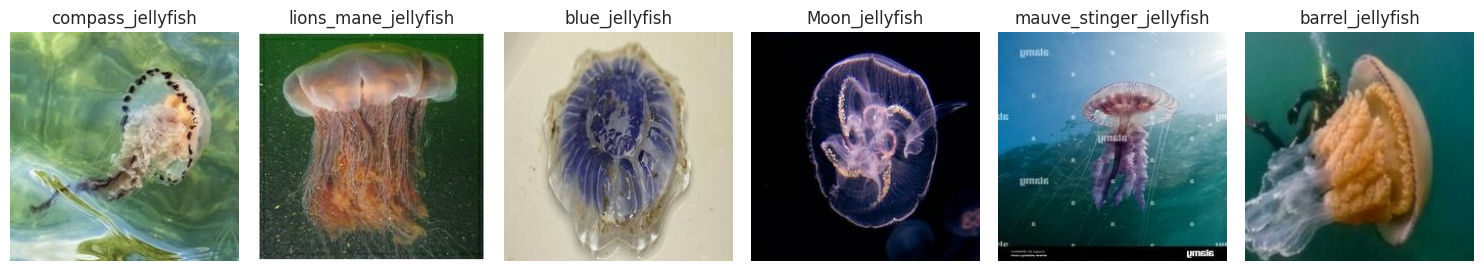

In [11]:
# class_labels = train.class_names
class_labels = list(train_generator.class_indices.keys()) # 수정

plt.figure(figsize=(15, 10))

shown_classes = set()

for images, labels in train.take(1):
    for i in range(len(images)):
        class_name = class_labels[labels[i]]
        if class_name not in shown_classes:
            ax = plt.subplot(1, 6, len(shown_classes) + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")
            shown_classes.add(class_name)

        if len(shown_classes) == len(class_labels):
            break

plt.tight_layout()
plt.show()

In [12]:
run_name = f"vgg16-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
wandb.init(
    project="jellyfish-epoch15",
    name=run_name,
    )

config = wandb.config
config.learning_rate = 0.001
config.batch_size = 16
config.epochs = 15
config.optimizer = "adam"
config.model = "VGG16"


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jungfsg (jungfsg-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [13]:
# 모델 정의
base_model = tf.keras.applications.VGG16(
    include_top=False,  # 완전 연결 레이어 제외
    weights='imagenet',
    input_shape=(224, 224, 3)  # 입력 이미지 크기
)

base_model.trainable = False

# 새로운 분류 헤드 추가
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(train.class_names), activation='softmax')  # 해파리 클래스 수에 맞게
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# wandb 콜백 커스텀(VGG16 기반에서 기본 콜백함수는 오류가 자주 생긴다고 함)

class MyWandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            wandb.log(logs, step=epoch)


In [16]:
# fit
# 수정
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=15,
        callbacks=[MyWandbCallback()]
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.2376 - loss: 1.7595 - val_accuracy: 0.5897 - val_loss: 1.4333
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.5319 - loss: 1.3517 - val_accuracy: 0.6154 - val_loss: 1.2589
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5887 - loss: 1.1490 - val_accuracy: 0.6667 - val_loss: 1.1990
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6710 - loss: 0.9925 - val_accuracy: 0.5128 - val_loss: 1.1601
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.7001 - loss: 0.9087 - val_accuracy: 0.6154 - val_loss: 1.1169
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.7045 - loss: 0.8113 - val_accuracy: 0.5897 - val_loss: 1.0864
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.7740 - loss: 0.7168 - val_accuracy: 0.5897 - val_loss: 1.1339
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.7624 - loss: 0.7391 - val_accuracy: 

In [18]:
test_data=os.path.join(train_test_valid_path, 'test')
pd.DataFrame(os.listdir(test_data),columns=['Files_Name'])

,Files_Name
0,Moon_jellyfish
1,blue_jellyfish
2,mauve_stinger_jellyfish
3,barrel_jellyfish
4,lions_mane_jellyfish
5,compass_jellyfish


In [19]:
test= tf.keras.preprocessing.image_dataset_from_directory(
    test_data,
    image_size=(224,224),
    validation_split=None,
)

Found 40 files belonging to 6 classes.


In [25]:
validation_rescaled = validation.map(lambda x, y: (x / 255.0, y))

valid_score, valid_acc = model.evaluate(validation_rescaled)
print('Val Loss =', valid_score)
print('Val Accuracy =', valid_acc)

test_score, test_acc = model.evaluate(test)
print('Test Loss =', test_score)
print('Test Accuracy =', test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5655 - loss: 1.4027 
Val Loss = 1.2539337873458862
Val Accuracy = 0.6153846383094788
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7833 - loss: 3.5623
Test Loss = 3.288243055343628
Test Accuracy = 0.800000011920929


In [26]:
Accuracy = [('valid', valid_score, valid_acc),
          ('test', test_score, test_acc)
         ]

predict_test = pd.DataFrame(data = Accuracy, columns=['Model', 'loss', 'accuracy'])
predict_test

,Model,loss,accuracy
0,valid,1.253934,0.615385
1,test,3.288243,0.800000
